$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in the VAE part.

In [2]:
import dataloader.plot as plot
import dataloader.download
from models.hyper_parameters import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = dataloader.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\Admin\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\Admin\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\Admin\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

In [ ]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


The following representation of GAN is from <a href='https://www.youtube.com/watch?v=98V7VRAFJGM&t=5490s'>Prof. Alex Bronstein's lecture on Generative Models</a>.

<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

In [1]:
import models.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

ModuleNotFoundError: No module named 'hw3'

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

Generator(
  (fc): Linear(in_features=128, out_features=16384, bias=True)
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

We want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.<br/>
Note: The discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

In [2]:
from models.gan import discriminator_loss_fn
from models.gan import generator_loss_fn


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

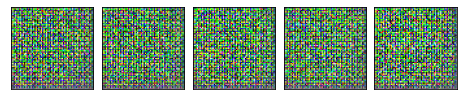

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from models.hyper_parameters import part3_gan_hyperparams

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.01, 'betas': (0.5, 0.99), 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.01, 'betas': (0.5, 0.99), 'lr': 0.0001}}


--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 0.38020882569253445
Generator loss:     7.218642143642201


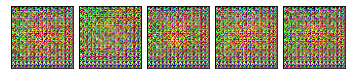

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.601289378150421
Generator loss:     7.446113979115205


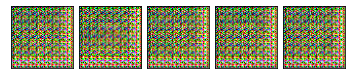

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.8081309383406359
Generator loss:     10.741873600903679


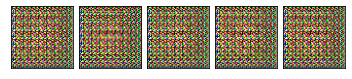

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.21300006559228196
Generator loss:     8.97020826620214
Saved checkpoint.


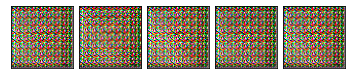

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.015243922250674051
Generator loss:     8.821503821541281
Saved checkpoint.


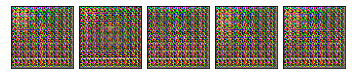

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.244365289916887
Generator loss:     10.111989806680118


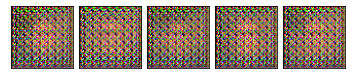

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.46578250118695635
Generator loss:     6.19051108640783


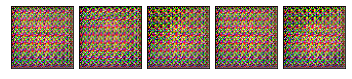

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.07205679716871065
Generator loss:     7.491214079015395


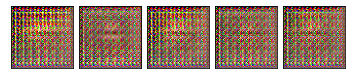

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.05022432939971194
Generator loss:     7.864530759699204


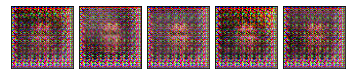

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.5989112795933205
Generator loss:     7.857013520072488


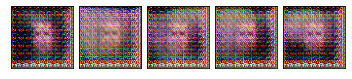

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.4986850575489156
Generator loss:     4.858586732079001
Saved checkpoint.


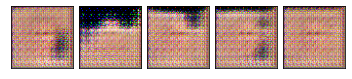

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.3633918108089882
Generator loss:     4.91747717296376


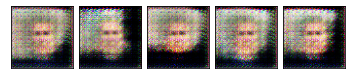

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.6058231679832234
Generator loss:     4.093803882598877


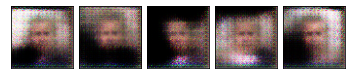

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 0.6809196524760303
Generator loss:     3.0606777597876156


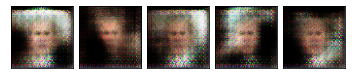

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 0.8381815381786403
Generator loss:     3.5696709015790153


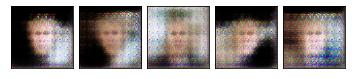

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 0.28181302027009864
Generator loss:     3.5246736302095303
Saved checkpoint.


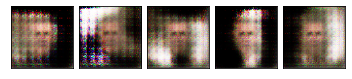

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 1.1532244594658123
Generator loss:     2.95007824196535


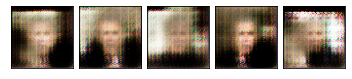

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 0.5276264351080445
Generator loss:     4.2548312053960915


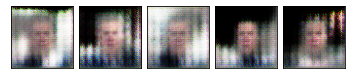

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.5913111251943252
Generator loss:     3.8766447165433098


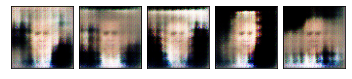

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.41072651787715797
Generator loss:     4.011276006698608


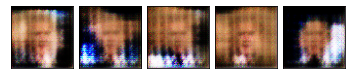

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.7787399134215187
Generator loss:     3.450443783227135


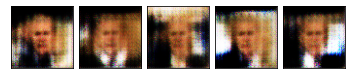

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.4094533542280688
Generator loss:     4.334247771431418


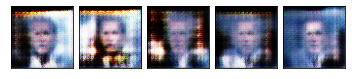

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 0.4524933857952847
Generator loss:     4.40213997223798


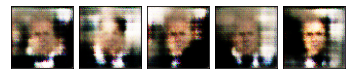

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.5930632305715013
Generator loss:     4.679286634220796


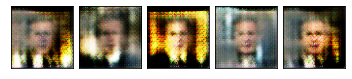

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.45178907802876306
Generator loss:     3.8052766463335823
Saved checkpoint.


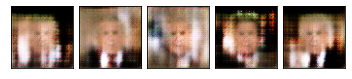

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 0.8339396141031209
Generator loss:     3.2212822858025048


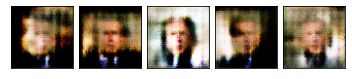

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 0.2806971046306631
Generator loss:     4.0527244315427895


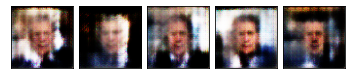

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 1.356637164073832
Generator loss:     3.2770727978033176


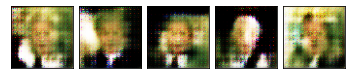

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.5098808004575617
Generator loss:     2.358363796682919
Saved checkpoint.


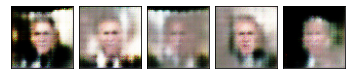

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.4726794480400927
Generator loss:     3.4345840215682983


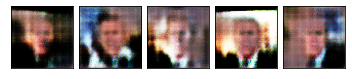

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.38154953893493204
Generator loss:     3.3564553962034336
Saved checkpoint.


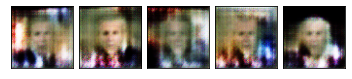

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.44108544268152294
Generator loss:     3.9478975885054646


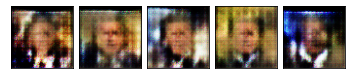

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.1275582692640669
Generator loss:     4.519673859371858


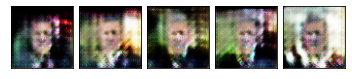

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.7359300409169758
Generator loss:     4.035579730482662


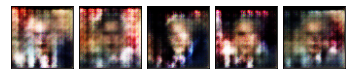

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 0.5943201705813408
Generator loss:     4.374552193809958


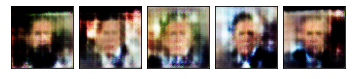

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.9213926533565802
Generator loss:     3.6038593264187084


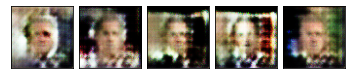

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.29414281994104385
Generator loss:     2.577261475955739
Saved checkpoint.


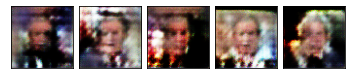

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.652190205805442
Generator loss:     3.5856434176949894


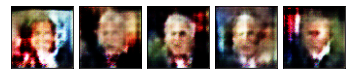

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.4487724383087719
Generator loss:     2.7010174919577206
Saved checkpoint.


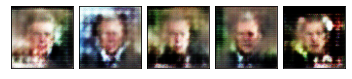

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.655629030045341
Generator loss:     2.94532030470231


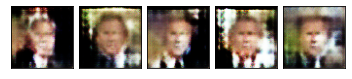

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.3071884929257281
Generator loss:     3.5847383667440975


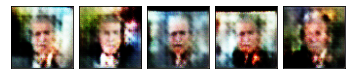

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.1261027155115324
Generator loss:     4.21744039479424


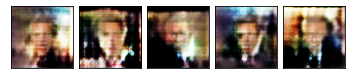

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.5709049936164828
Generator loss:     3.991050131180707


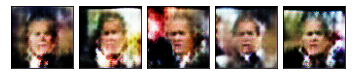

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.18260710067389643
Generator loss:     4.1875287785249595


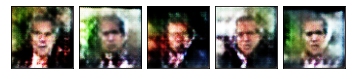

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.8588694877484265
Generator loss:     3.176866235101924


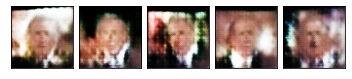

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.40828318455640006
Generator loss:     3.69623802689945


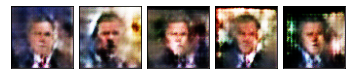

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.96it/s]
Discriminator loss: 0.22804883253924987
Generator loss:     4.391828663208905


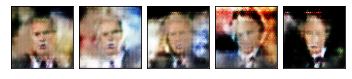

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.49265675180975127
Generator loss:     4.315605444066665


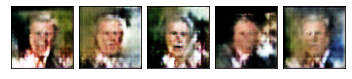

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.17269215119235656
Generator loss:     4.253073061213774
Saved checkpoint.


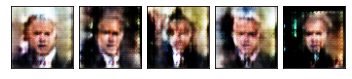

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
Discriminator loss: 0.34959429896929684
Generator loss:     4.767895137562471


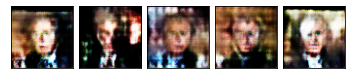

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.3943912546862574
Generator loss:     4.5222263897166535


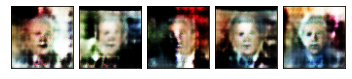

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.37051677002626304
Generator loss:     4.3381968386033005
Saved checkpoint.


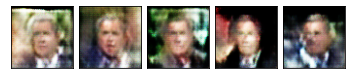

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.29343534896478934
Generator loss:     5.046585475697237


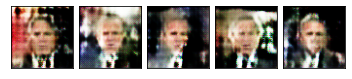

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.2865127889877733
Generator loss:     5.201624533709357


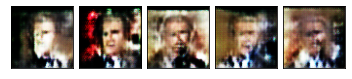

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 1.247161808259347
Generator loss:     2.7442524117581986


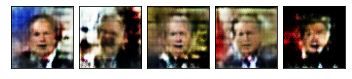

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.4824771263143596
Generator loss:     3.1859425201135525


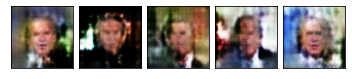

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.14866360912428184
Generator loss:     4.09597848443424


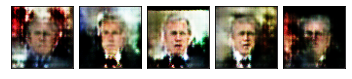

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.13182883611058488
Generator loss:     4.549684917225557


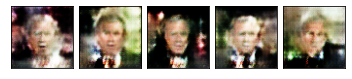

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 0.7067159406621667
Generator loss:     4.3246797182980705


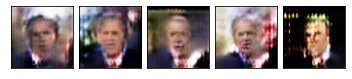

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.47711884044110775
Generator loss:     4.4361651504741


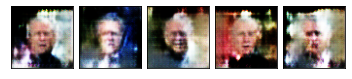

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.2840405980892041
Generator loss:     4.367068676387563
Saved checkpoint.


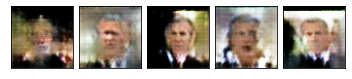

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.2983423553626327
Generator loss:     4.824469973059261


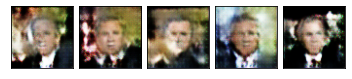

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.1428349790546824
Generator loss:     4.987911981694839


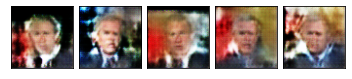

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 0.3451855640639277
Generator loss:     4.9475047027363495


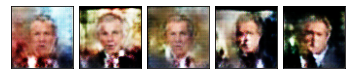

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.42690247560248656
Generator loss:     4.653694222955143


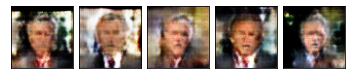

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.92it/s]
Discriminator loss: 0.23900840628673048
Generator loss:     5.125229218426873


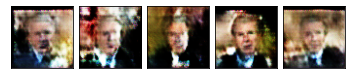

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.8801914339556414
Generator loss:     3.8966431968352375


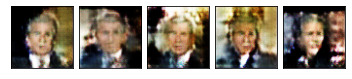

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.13184020471046953
Generator loss:     3.5082632233114803
Saved checkpoint.


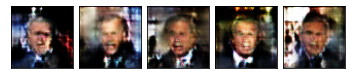

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 0.12804016032639673
Generator loss:     4.531430987750783


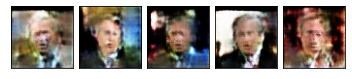

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
Discriminator loss: 0.3975736369543216
Generator loss:     4.607385088415707


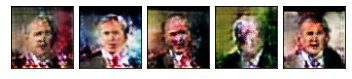

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.5750393218853894
Generator loss:     3.192740994341233


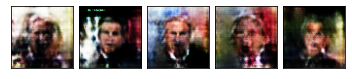

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.6275698345373658
Generator loss:     4.021008677342358


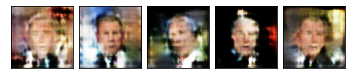

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
Discriminator loss: 0.44589026973528023
Generator loss:     4.5723459019380455


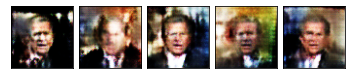

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.97it/s]
Discriminator loss: 0.12417439174126177
Generator loss:     4.902974030550788


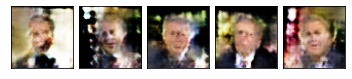

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 1.1754223568474544
Generator loss:     3.364812325028812


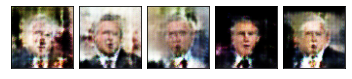

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.1866113721009563
Generator loss:     3.248433323467479
Saved checkpoint.


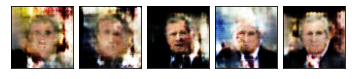

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.94it/s]
Discriminator loss: 0.1814589435234666
Generator loss:     4.053516538704143


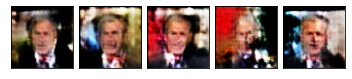

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.3751932671841453
Generator loss:     3.881432561313405


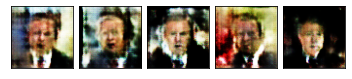

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.23342273937647834
Generator loss:     4.718005208408131


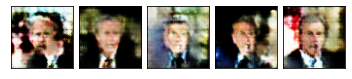

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 0.11867642643697121
Generator loss:     4.583497145596673
Saved checkpoint.


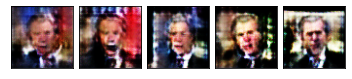

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.45818044639685573
Generator loss:     5.192675562465892


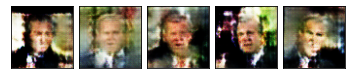

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.10055473370148856
Generator loss:     3.8071117401123047
Saved checkpoint.


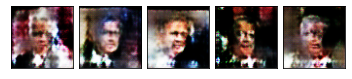

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.07371766772121191
Generator loss:     5.349641968222225


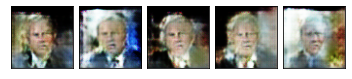

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.5970868490198079
Generator loss:     4.471554531770594


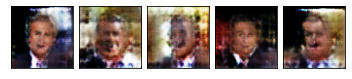

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.492195294402978
Generator loss:     4.655187922365525


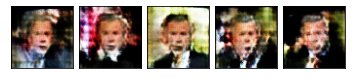

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.18085557310020223
Generator loss:     4.786999029271743


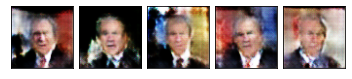

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.92it/s]
Discriminator loss: 0.20689164693741238
Generator loss:     5.658155721776626


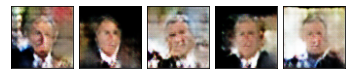

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 0.3621041744070895
Generator loss:     5.784444654689116


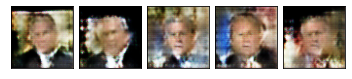

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.7121548606630634
Generator loss:     3.821713181102977


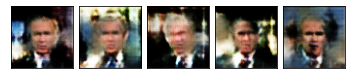

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 0.07971196435391903
Generator loss:     4.751325929866118


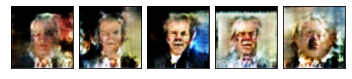

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.11461057513952255
Generator loss:     5.120831587735345


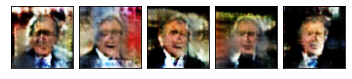

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 0.03220432251691818
Generator loss:     6.1829736092511345


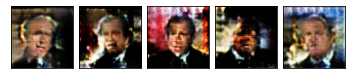

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.7204240211011732
Generator loss:     5.125960427172044


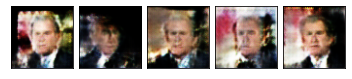

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.07154165087815594
Generator loss:     3.9422585683710434
Saved checkpoint.


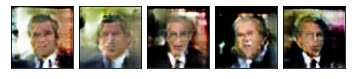

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.39940383767380433
Generator loss:     4.5882112559150245


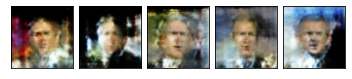

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.13144160478430636
Generator loss:     4.994031401241527


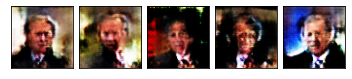

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 0.7060967778020045
Generator loss:     5.238274128998027


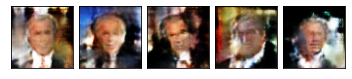

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.31198205798864365
Generator loss:     4.302189883063821
Saved checkpoint.


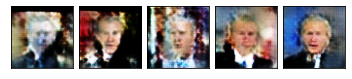

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.1779593914089834
Generator loss:     4.976471059462604


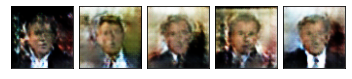

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
Discriminator loss: 0.36806480082518916
Generator loss:     5.511833758915172


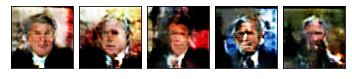

In [12]:
import IPython.display
import tqdm
from models.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            
        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


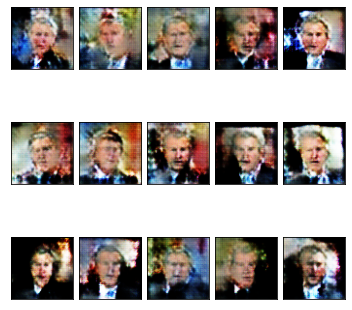

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))